In [1]:
import keras 
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

In [4]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options = gpu_options))

In [5]:
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
#get current work direction
model_name = 'keras_cifar10_trained_model.h5'

In [35]:
# 檢查Dataset 的描述與資訊
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0],'train samples')
print(x_test.shape[0],'test samples')

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
#keras.utils.to_categorical(y, num_classes=None, dtype='float32')
#y: 需要转换成矩阵的类矢量 (从 0 到 num_classes 的整数)
#num_classes: 总类别数

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [36]:
# 第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
model = Sequential()
# 第二步：構建網絡層
model.add(Conv2D(32,(3,3),padding = 'same', input_shape = x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(10))# 輸出結果是10個類別，所以維度是10
model.add(Activation('softmax'))# 最後一層用softmax作為激活函數

In [13]:
# 模型建立完成後，統計參數總量
print('Total Parameters:%d' % model.count_params())

Total Parameters:1250858


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [15]:
#第三步:編譯
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0922 19:56:20.179080  9532 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\DL\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0922 19:56:20.204874  9532 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\DL\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [26]:
#資料正規化
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [17]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train,y_train, batch_size=batch_size, 
                        epochs=epochs, validation_data=(x_test,y_testte),shuffle=True)

else:
    print('Using real-time data augmentation.')
    print('')
    #面对小数据集，我们往往需要利用Image Data Augmentation图像增广技术来扩充我们的数据集
    # This will do preprocessing and realtime data augmentation:
    # https://zhuanlan.zhihu.com/p/30197320
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    # Compute quantities required for feature-wise normalization
    #(std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    history = model.fit(x_train, y_train, batch_size=batch_size, 
                        epochs=epochs, validation_data=(x_test, y_test),shuffle=True)
'''
   第四步：訓練
   .fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
'''

Using real-time data augmentation.



W0922 23:47:56.849150  9532 deprecation.py:323] From C:\Users\User\Anaconda3\envs\DL\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 97s 2ms/step - loss: 1.5286 - acc: 0.4442 - val_loss: 1.1150 - val_acc: 0.6030
Epoch 2/20
50000/50000 [==============================] - 94s 2ms/step - loss: 1.1117 - acc: 0.6076 - val_loss: 0.8887 - val_acc: 0.6907
Epoch 3/20
50000/50000 [==============================] - 91s 2ms/step - loss: 0.9394 - acc: 0.6705 - val_loss: 0.8591 - val_acc: 0.7002
Epoch 4/20
50000/50000 [==============================] - 91s 2ms/step - loss: 0.8428 - acc: 0.7057 - val_loss: 1.0023 - val_acc: 0.6676
Epoch 5/20
50000/50000 [==============================] - 92s 2ms/step - loss: 0.7796 - acc: 0.7271 - val_loss: 0.7587 - val_acc: 0.7392
Epoch 6/20
50000/50000 [==============================] - 90s 2ms/step - loss: 0.7255 - acc: 0.7442 - val_loss: 0.7171 - val_acc: 0.7548
Epoch 7/20
50000/50000 [==============================] - 87s 2ms/step - loss: 0.6899 - acc: 0.7592 - val_loss: 0.7093 - val_acc

'\n   第四步：訓練\n   .fit的一些參數\n   batch_size：對總的樣本數進行分組，每組包含的樣本數量\n   epochs ：訓練次數\n   shuffle：是否把數據隨機打亂之後再進行訓練\n   validation_split：拿出百分之多少用來做交叉驗證\n   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果\n'

In [18]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s' % model_path)

# 第六步: 輸出
# Score trained model.
score = model.evaluate(x_test,y_test, verbose =1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Saved trained model at C:\Users\User\Documents\GitHub\100Day-ML-Marathon\homework\saved_models\keras_cifar10_trained_model.h5
10000/10000 [==============================] - 5s 522us/step
Test loss: 0.6709561550617218
Test accuracy: 0.7857


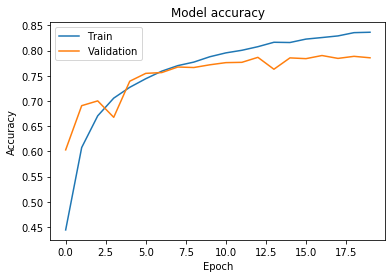

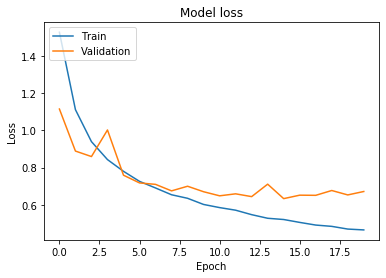

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 功課 

In [22]:
# 第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
model = Sequential()
# 第二步：構建網絡層
model.add(Conv2D(32,(3,3),padding = 'same', input_shape = x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(10))# 輸出結果是10個類別，所以維度是10
model.add(Activation('softmax'))# 最後一層用softmax作為激活函數

In [24]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train,y_train, batch_size=batch_size, 
                        epochs=epochs, validation_data=(x_test,y_testte),shuffle=True)

else:
    print('Using real-time data augmentation.')
    print('')
    #面对小数据集，我们往往需要利用Image Data Augmentation图像增广技术来扩充我们的数据集
    # This will do preprocessing and realtime data augmentation:
    # https://zhuanlan.zhihu.com/p/30197320
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    # Compute quantities required for feature-wise normalization
    #(std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    history = model.fit(x_train, y_train, batch_size=batch_size, 
                        epochs=epochs, validation_data=(x_test, y_test),shuffle=True)
'''
   第四步：訓練
   .fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
'''

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 85s 2ms/step - loss: 2.0777 - acc: 0.2307 - val_loss: 1.8554 - val_acc: 0.3435
Epoch 2/20
50000/50000 [==============================] - 88s 2ms/step - loss: 1.7644 - acc: 0.3602 - val_loss: 1.7703 - val_acc: 0.3740
Epoch 3/20
50000/50000 [==============================] - 86s 2ms/step - loss: 1.5258 - acc: 0.4465 - val_loss: 1.3676 - val_acc: 0.5056
Epoch 4/20
50000/50000 [==============================] - 84s 2ms/step - loss: 1.3896 - acc: 0.4987 - val_loss: 1.2414 - val_acc: 0.5619
Epoch 5/20
50000/50000 [==============================] - 85s 2ms/step - loss: 1.2970 - acc: 0.5363 - val_loss: 1.1625 - val_acc: 0.5852
Epoch 6/20
50000/50000 [==============================] - 86s 2ms/step - loss: 1.2223 - acc: 0.5638 - val_loss: 1.1638 - val_acc: 0.5863
Epoch 7/20
50000/50000 [==============================] - 85s 2ms/step - loss: 1.1632 - acc:

'\n   第四步：訓練\n   .fit的一些參數\n   batch_size：對總的樣本數進行分組，每組包含的樣本數量\n   epochs ：訓練次數\n   shuffle：是否把數據隨機打亂之後再進行訓練\n   validation_split：拿出百分之多少用來做交叉驗證\n   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果\n'

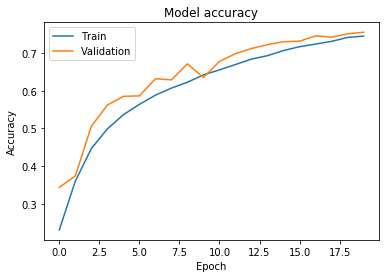

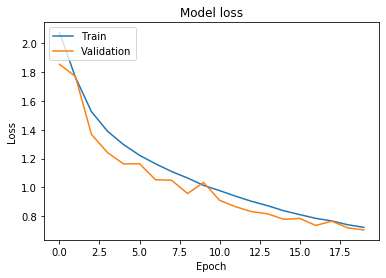

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# 第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
model = Sequential()
# 第二步：構建網絡層
model.add(Conv2D(32,(3,3),padding = 'same', input_shape = x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(10))# 輸出結果是10個類別，所以維度是10
model.add(Activation('softmax'))# 最後一層用softmax作為激活函數
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 功課-2

In [29]:
# 第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
model = Sequential()
# 第二步：構建網絡層
model.add(Conv2D(32,(3,3),padding = 'same', input_shape = x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(10))# 輸出結果是10個類別，所以維度是10
model.add(Activation('softmax'))# 最後一層用softmax作為激活函數

In [37]:
from keras import optimizers
rm = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model.compile(optimizer=rm, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train,y_train, batch_size=batch_size, 
                        epochs=epochs, validation_data=(x_test,y_testte),shuffle=True)

else:
    print('Using real-time data augmentation.')
    print('')
    #面对小数据集，我们往往需要利用Image Data Augmentation图像增广技术来扩充我们的数据集
    # This will do preprocessing and realtime data augmentation:
    # https://zhuanlan.zhihu.com/p/30197320
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    # Compute quantities required for feature-wise normalization
    #(std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    history = model.fit(x_train, y_train, batch_size=batch_size, 
                        epochs=epochs, validation_data=(x_test, y_test),shuffle=True)
'''
   第四步：訓練
   .fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
'''

Using real-time data augmentation.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 94s 2ms/step - loss: 14.5079 - acc: 0.0999 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 101s 2ms/step - loss: 14.5066 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 92s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 102s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 103s 2ms/step - loss: 14.5081 - acc: 0.0999 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 102s 2ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 102s 2ms/step - lo

'\n   第四步：訓練\n   .fit的一些參數\n   batch_size：對總的樣本數進行分組，每組包含的樣本數量\n   epochs ：訓練次數\n   shuffle：是否把數據隨機打亂之後再進行訓練\n   validation_split：拿出百分之多少用來做交叉驗證\n   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果\n'

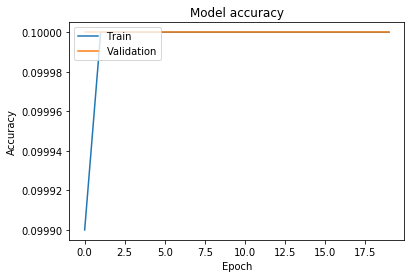

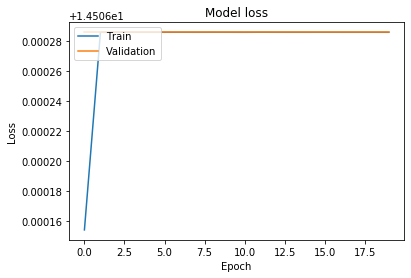

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# 第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
model = Sequential()
# 第二步：構建網絡層
model.add(Conv2D(32,(3,3),padding = 'same', input_shape = x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
          
model.add(Dense(10))# 輸出結果是10個類別，所以維度是10
model.add(Activation('softmax'))# 最後一層用softmax作為激活函數
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()